# Introduction

https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6

### What Are the Applications of Autoencoders?

* dimensionality reduction.  
* computer vision and image editing. In image coloring, autoencoders are used to convert a black-and-white image to a colored image. In image noise reduction, autoencoders are used to remove noises. 

### Why Do We Apply Dimensionality Reduction to Find Outliers?

* Don’t we lose some information, including the outliers, if we reduce the dimensionality? The answer is once the main patterns are identified, the outliers are revealed. Many distance-based techniques (e.g. KNNs) suffer the curse of dimensionality when they compute distances of every data point in the full feature space. High dimensionality has to be reduced. Interestingly, during the process of dimensionality reduction outliers are identified. We can say outlier detection is a by-product of dimension reduction.

### Why Autoencoders?

* See the general notes on anomaly detection about why autoencoders are used. Below is only very brief description. 

* There are already many useful tools such as Principal Component Analysis (PCA) to detect outliers, why do we need the autoencoders? Recall that the PCA uses linear algebra to transform  In contrast, the autoencoder techniques can perform non-linear transformations with their non-linear activation function and multiple layers. 

* It is more efficient to train several layers with an autoencoder, rather than training one huge transformation with PCA. The autoencoder techniques thus show their merits when the data problems are complex and non-linear in nature.

# Steps for anomaly detection

* See similar steps in PyOD_with_KNN.ipynb. 

* Unlike using PyOD with KNN model, here we focus on an autocoder. KNN is a classification model (supervised) while autoencoder here is an unsupervised model. Compare the difference of their implementation in the three steps. 

### Build the Model

* Use the utility function generate_data() of PyOD to generate 25 variables, 500 observations and ten percent outliers.
* You may wonder why I generate up to 25 variables. Recall that in an autoencoder model the number of the neurons of the input and output layers corresponds to the number of variables, and the number of neurons of the hidden layers is always less than that of the outside layers. An example with more variables will allow me to show you a different number of hidden layers in the neural networks.

In [1]:
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features, 
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

Using TensorFlow backend.
C:\Users\ljyan\anaconda3\envs\tensorflow-gpu\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


When you do unsupervised learning, it is always a safe step to standardize the predictors like below:

In [2]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In order to give you a good sense of what the data look like, I use PCA reduce to two dimensions and plot accordingly.

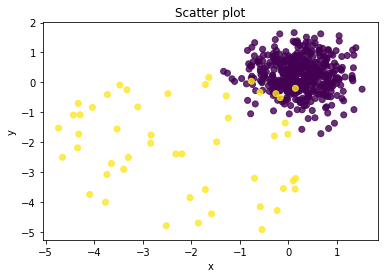

In [3]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

* The purple points clustering together are the “normal” observations, and the yellow points are the outliers.

* Model specification: Hyper-parameter testing in a neural network model deserves a separate article. Because the goal of this article is to walk you through the entire process, I will just build three plain-vanilla models with different number of layers:

In [ ]:
Model 1: [25, 2, 2, 25]. The input layer and the output layer has 25 neurons each. There are two hidden layers, each has two neurons.
Model 2: [25, 10, 2, 10, 25]. Besides the input layer and output layers, there are three hidden layers with 10, 2, and 10 neurons respectively.
Model 3: [25, 15, 10, 2, 10, 15, 25]. There are five hidden layers with 15, 10, 2, 10, 15 neurons respectively.

* I will purposely repeat the same procedure for Model 1, 2, and 3. Feel free to skim through Model 2 and 3 if you get a good understanding from Model 1.

### Model 1 — Step 1 — Build Your Model

In [5]:
clf1 = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf1.fit(X_train)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
________________________________________________

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000019D8E3B1C18>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

**Question:**  
* We only use the train_data, why is there the value_loss? 
* In one of autoencoder article about credit-card risk prediction, only normal sample (no outliers) are used to train the autoencoders. How about here? 

### Model 1 — Step 2 — Determine the Cut Point

* Let’s apply the trained model Clf1 to predict the anomaly score for each observation in the test data. How do we define an outlier? An outlier is a point that is distant from other points, so the outlier score is defined by distance. The PyOD function .decision_function() calculates the distance or the anomaly score for each data point.

In [6]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

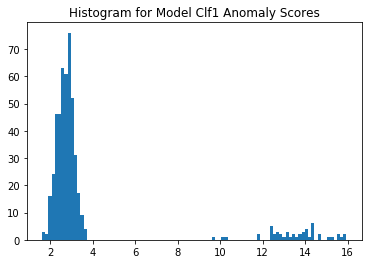

In [6]:
# Plot it!
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show() 

* If we use a histogram to count the frequency by the anomaly score, we will see the high scores corresponds to low frequency — the evidence of outliers. We choose 4.0 to be the cut point and those >=4.0 to be outliers. 

### Model 1 — Step 3 — Get the Summary Statistics by Cluster

* Let’s assign those observations with less than 4.0 anomaly scores to Cluster 0, and to Cluster 1 for those above 4.0 (see how I use np.where() in the code). I calculate the summary statistics by cluster using .groupby() . This model has identified 50 outliers (not shown).

In [7]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.248812,0.235591,0.254013,0.239429,0.239101,0.255499,0.257207,0.24438,0.248004,0.251948,...,0.247737,0.251469,0.259140,0.249625,0.235669,0.244511,0.237602,0.246901,0.249373,2.711020
1,-2.239305,-2.120321,-2.286113,-2.154863,-2.151912,-2.299489,-2.314860,-2.19942,-2.232040,-2.267535,...,-2.229637,-2.263223,-2.332263,-2.246622,-2.121021,-2.200595,-2.138417,-2.222110,-2.244355,13.510501
